In [1]:
# import trax
# from trax import layers as tl
# import trax.fastmath.numpy as fastnp
# from trax.supervised import training
from functools import partial
import numpy as np
from itertools import combinations
import random as rnd
from random import sample
import json
import sklearn.metrics as metrics
from sklearn.metrics import classification_report , confusion_matrix, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import copy
import torch
import os
import warnings
from scipy.spatial import distance
from os import walk
from transformers import AutoTokenizer, AutoModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#initialize codebert
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model_codebert = AutoModel.from_pretrained("microsoft/codebert-base").to(device)
np.random.seed(777)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from os import walk

from transformers import AutoModelForCausalLM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:

int_to_label_pre = {
    0: 'notFlaky',
    1: 'Flaky',
    
}

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = "/home/riddhi/FlakyXbert/MAIN/data/IDoFT_data/Flakify_IDoFT_dataset.csv"
data = pd.read_csv(file_path)

# Filter data for a specific project
project_name = "adyen-java-api-library"  # Replace 'YourProjectName' with the actual project name
filtered_data = data[data['project'] == project_name]  # Replace 'project' with the actual column name identifying the project

# Extract the relevant fields: 'preprocessed_code' and 'flaky'
relevant_data = filtered_data[['preprocessed_code', 'flaky']]

# Split the data into training and validation sets, stratifying by 'flaky' to ensure all categories are represented
train_data, valid_data = train_test_split(relevant_data, test_size=0.2, random_state=42, stratify=relevant_data['flaky'])

# Replace category numbers with category labels
# Ensure 'int_to_label_pre' is defined, mapping integer labels to their corresponding category names
train_data['category'] = train_data['flaky'].map(int_to_label_pre)
valid_data['category'] = valid_data['flaky'].map(int_to_label_pre)

# Extract buggy code and categories for train and validation sets
train_buggy_code = train_data['preprocessed_code'].tolist()
valid_buggy_code = valid_data['preprocessed_code'].tolist()
train_categories = train_data['category'].tolist()
valid_categories = valid_data['category'].tolist()

# Print the splits for verification
print("Train buggy code:", len(train_buggy_code))
print("Validation buggy code:", len(valid_buggy_code))
print("Train categories:", len(train_categories))
print("Validation categories:", len(valid_categories))


Train buggy code: 71
Validation buggy code: 18
Train categories: 71
Validation categories: 18


In [5]:
label_to_int= {
    'notFlaky': 0,
    'Flaky': 1
    }

In [6]:
from torch.utils.data import Dataset
import numpy as np
import random
import torch

class SiameseDataset(Dataset):
    def __init__(self, train_buggy_code, valid_buggy_code, tokenizer, codebert, categories, split):
        self.train_buggy_code = train_buggy_code
        self.valid_buggy_code = valid_buggy_code
        self.tokenizer = tokenizer
        self.codebert = codebert.to(device)
        self.categories = categories
        self.split = split
        self.m_len = self.calculate_max_output_length()
        
        # Preprocess categories to map labels to indices
        self.label_to_indices = {}
        for index, category in enumerate(categories):
            if category not in self.label_to_indices:
                self.label_to_indices[category] = []
            self.label_to_indices[category].append(index)

        # For negative sampling
        self.labels = categories
        self.unique_labels = list(set(self.labels))
        
    def calculate_max_output_length(self):
        max_length = 0
        for code in self.train_buggy_code:
            # Simulate processing of snippets to determine the concatenated output length
            length = self.simulate_process_length(code)
            if length > max_length:
                max_length_train = length
        for code in self.valid_buggy_code:
            # Simulate processing of snippets to determine the concatenated output length
            length = self.simulate_process_length(code)
            if length > max_length:
                max_length_valid = length
        if max_length_train > max_length_valid:
            return max_length_train
        else:
            return max_length_valid

    def simulate_process_length(self, snippet):
        # Calculate how many segments would be needed
        encoded_input = self.tokenizer.encode(snippet, add_special_tokens=True)
        # Each segment processes up to 512 tokens (max length for BERT models)
        num_segments = (len(encoded_input) + 511) // 512  # 512 tokens per segment, including CLS and SEP
        return num_segments * 768
    def __len__(self):
        if self.split == 'train':
            return len(self.train_buggy_code)
        else:
            return len(self.valid_buggy_code)

    def __getitem__(self, idx):
        if self.split == 'train':
            # Anchor label
            anchor_label = self.categories[idx]

            # Positive sample
            positive_idx = idx
            while positive_idx == idx:  # Ensure different indices for anchor and positive
                positive_idx = random.choice(self.label_to_indices[anchor_label])

            # Negative sample
            negative_label = random.choice([lab for lab in self.unique_labels if lab != anchor_label])
            negative_idx = random.choice(self.label_to_indices[negative_label])

            anchor = self._process_snippet(self.train_buggy_code[idx])
            positive = self._process_snippet(self.train_buggy_code[positive_idx])
            negative = self._process_snippet(self.train_buggy_code[negative_idx])
            
            if len(anchor) <= 768:
                short_data = True
            else:
                short_data = False
                


            return {
                'anchor': torch.nn.functional.pad(anchor, (0, self.m_len - anchor.size(0))),
                'positive':torch.nn.functional.pad(positive, (0, self.m_len - positive.size(0))),
                'negative': torch.nn.functional.pad(negative, (0, self.m_len - negative.size(0))),
                'label': label_to_int[anchor_label],  # Optional, depends on how you want to use it
                'short_data_flag': short_data
            }
        elif self.split == 'val':
            anchor_label = self.categories[idx]
            anchor = self._process_snippet(self.valid_buggy_code[idx])
            
            return {
                'anchor': torch.nn.functional.pad(anchor, (0, self.m_len - anchor.size(0))),
                'label': label_to_int[anchor_label]  # Optional, depends on how you want to use it
            }

        
    def _process_snippet(self, snippet):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Tokenize input without the max_length constraint
        inputs = self.tokenizer(snippet, return_tensors='pt').to(device)

        if inputs['input_ids'].shape[1] < 512:
            with torch.no_grad():
                outs = self.codebert(**inputs)
            cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
            return cls  # Move to CPU to save GPU memory
        else:
            total_length = inputs['input_ids'].shape[1]
            parts = []
            step_size = 100
            chunk_size = 512

            for start_index in range(0, total_length, step_size):
                end_index = min(start_index + chunk_size, total_length)
                input_segment = {key: val[:, start_index:end_index].to(device) for key, val in inputs.items()}

                with torch.no_grad():
                    output_segment = self.codebert(**input_segment)
                cls_segment = output_segment.last_hidden_state[:, 0, :].squeeze().detach()
                parts.append(cls_segment)  # Move to CPU

            concatenated_parts = torch.cat(parts, dim=0)
            return concatenated_parts

In [7]:
# Create instances of the custom dataset class
train_dataset = SiameseDataset(train_buggy_code, valid_buggy_code, tokenizer, model_codebert, train_categories, 'train')
val_dataset = SiameseDataset(train_buggy_code, valid_buggy_code, tokenizer, model_codebert, valid_categories, 'val')

# Create dataloaders for training and validation
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Print the lengths of the dataloaders for verification
print("Train dataloader length:", len(train_dataloader))
print("Validation dataloader length:", len(val_dataloader))

Train dataloader length: 36
Validation dataloader length: 9


In [8]:
import numpy as np

def sample_triplet_data(data, sample_size_ratio):
    """
    Samples a subset of triplet data (anchor, positive, negative) while preserving class distribution.
    
    Parameters:
    - data: list of dictionaries, where each dictionary has keys 'anchor', 'positive', 'negative', 'label'.
    - sample_size_ratio: float, the fraction of the data to sample (0 < sample_size_ratio <= 1).
    
    Returns:
    - sampled_data: list of dictionaries, the sampled subset of the original data.
    """
    # Extract labels to understand the class distribution
    labels = [item['label'] for item in data]
    unique_classes = np.unique(labels)
    
    sampled_data = []
    
    for cls in unique_classes:
        # Find all items belonging to the current class
        class_items = [item for item in data if item['label'] == cls]
        # Calculate the number of items to sample from this class
        num_samples = int(np.ceil(len(class_items) * sample_size_ratio))
        # Randomly sample items without replacement
        sampled_items = np.random.choice(class_items, size=num_samples, replace=False)
        # Append the sampled items to the output list
        sampled_data.extend(sampled_items)
    
    # Optionally, shuffle the sampled dataset to mix classes
    np.random.shuffle(sampled_data)

    return sampled_data


In [9]:
import gc
from tqdm import tqdm
plot_data = []
plot_labels = []
short_data_flags = []
for item in tqdm(train_dataset):
    
    plot_data.append(item['anchor'])
    plot_labels.append(item['label'])
    short_data_flags.append(item['short_data_flag'])

  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 71/71 [00:00<00:00, 110.12it/s]


In [10]:
m_len = plot_data[0].shape[0]

In [11]:
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']  
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Create a custom colormap
cc = LinearSegmentedColormap.from_list("cc", colors, N=5)


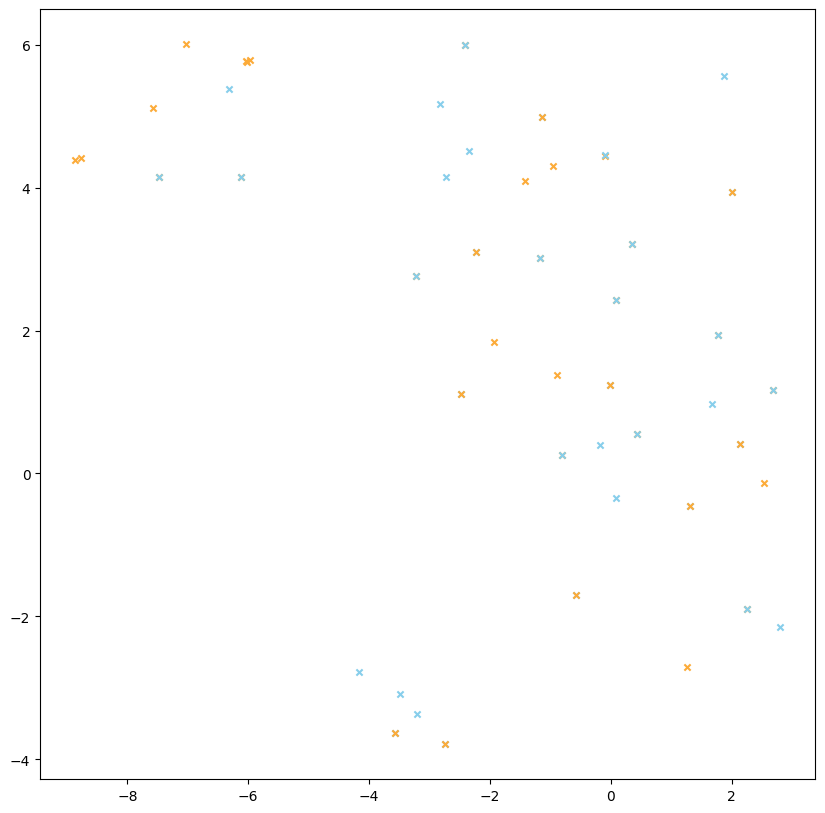

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

# Assuming X, plot_data, and plot_labels are defined as before
# Also assuming bool_values is your list/array of boolean values

X = torch.stack(plot_data).cpu().numpy()

# Extract labels for each point
labelsNums = plot_labels

# Perform t-SNE dimensionality reduction
X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

# Assuming 'cc' is a colormap, you might need to adjust this to fit your actual colormap variable
# Generate an array of colors for each label
unique_labels = np.unique(labelsNums)
colors = plt.cm.get_cmap(cc, len(unique_labels))  # Adjust 'cc' as needed to your colormap name
label_to_color = {label: colors(i / len(unique_labels)) for i, label in enumerate(unique_labels)}
colors_array = np.array([label_to_color[label] for label in labelsNums])

# Create the scatter plot
plt.figure(figsize=(10, 10))

# Iterate through each datapoint
for i in range(len(X_embedded)):
    marker = 'x' if short_data_flags[i] else 'o'  # Choose the marker based on the boolean value
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors_array[i], s=20, alpha=1, marker=marker)

# Set the background color to black
# plt.gca().set_facecolor('white')
# # Adjust the color of the ticks and labels for better visibility
# plt.tick_params(axis='x', colors='white')
# plt.tick_params(axis='y', colors='white')
# plt.xlabel('Component 1', color='white')
# plt.ylabel('Component 2', color='white')

plt.show()


In [13]:
# Load the CodeBERT tokenizer (adjust the model_name as needed)
model_name = "microsoft/codebert-base"
codebert_model = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(embedding_size, int(embedding_size/2)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/2), int(embedding_size/4)),
            nn.ReLU(inplace=True),
            nn.Linear(int(embedding_size/4), embedding_size)
        )

    def forward(self, x):
        output = self.fc(x)
        return output

In [14]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [15]:
learning_rate = 1e-5
num_epochs = 450
embed_size = m_len  # This should match the output size of CodeBERT
siamese_network = SiameseNetwork(embed_size).to(device)
criterion = TripletLoss(margin=1.0)
optimizer = optim.Adam(siamese_network.parameters(), lr=learning_rate)
triplet_loss = TripletLoss().to(device)

In [16]:
# from transformers import get_linear_schedule_with_warmup
# warmup_Frac = 0.1
# total_iter = num_epochs * len(train_dataloader)
# scheduler = get_linear_schedule_with_warmup(optimizer, int(warmup_Frac * total_iter), total_iter)

In [17]:
from tqdm import tqdm
best_loss = 100.0
num_epochs = 300
epoch_loss_list = []
model_name = "FlakyXbert_IDoFT_project_binary_" + project_name + '_final.pth'
for epoch in range(num_epochs):
    total_loss = 0.0
    siamese_network.train()
    for batch in tqdm(train_dataloader):

        labels = (batch['label']).to(device)
        batch_anchor = (batch['anchor']).to(device)
        batch_positive = (batch['positive']).to(device)
        batch_negative = (batch['negative']).to(device)

        anchor_output = siamese_network(batch_anchor)
        positive_out = siamese_network(batch_positive)
        negative_out = siamese_network(batch_negative)

        loss = criterion(anchor_output, positive_out, negative_out)
        optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(siamese_network.parameters(), max_norm=2.0)        
        optimizer.step()
        # scheduler.step()

        total_loss += loss.item()
        if total_loss <= best_loss:
            # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
            print("Loss improved saving model")
            torch.save(siamese_network.state_dict(), model_name)
            best_loss = total_loss
        
            
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    # The line `epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")` is attempting to append a formatted string to a list named `epoch_loss_list`. This string contains information about the current epoch number, total number of epochs, and the average loss calculated for that epoch. However, in the provided code snippet, the `epoch_loss_list` list is not defined or used anywhere else in the code.
    epoch_loss_list.append(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}")
    

 36%|███▌      | 13/36 [00:00<00:00, 62.98it/s]

Loss improved saving model


100%|██████████| 36/36 [00:00<00:00, 68.91it/s]


Epoch 1/300, Loss: 0.9958220256699456


100%|██████████| 36/36 [00:00<00:00, 74.29it/s]


Epoch 2/300, Loss: 0.9817844778299332


100%|██████████| 36/36 [00:00<00:00, 70.98it/s]


Epoch 3/300, Loss: 0.9871938708755705


100%|██████████| 36/36 [00:00<00:00, 73.80it/s]


Epoch 4/300, Loss: 1.0386197931236691


100%|██████████| 36/36 [00:00<00:00, 74.37it/s]


Epoch 5/300, Loss: 0.9896993736426035


100%|██████████| 36/36 [00:00<00:00, 74.55it/s]


Epoch 6/300, Loss: 1.0062114381127887


100%|██████████| 36/36 [00:00<00:00, 74.38it/s]


Epoch 7/300, Loss: 0.9713578008943133


100%|██████████| 36/36 [00:00<00:00, 74.71it/s]


Epoch 8/300, Loss: 1.011274932159318


100%|██████████| 36/36 [00:00<00:00, 74.94it/s]


Epoch 9/300, Loss: 0.9994123743640052


100%|██████████| 36/36 [00:00<00:00, 74.91it/s]


Epoch 10/300, Loss: 0.9978535572687784


100%|██████████| 36/36 [00:00<00:00, 74.60it/s]


Epoch 11/300, Loss: 0.966154158115387


100%|██████████| 36/36 [00:00<00:00, 75.19it/s]


Epoch 12/300, Loss: 0.9813646674156189


100%|██████████| 36/36 [00:00<00:00, 74.77it/s]


Epoch 13/300, Loss: 1.034204335676299


100%|██████████| 36/36 [00:00<00:00, 74.76it/s]


Epoch 14/300, Loss: 0.976250602139367


100%|██████████| 36/36 [00:00<00:00, 75.08it/s]


Epoch 15/300, Loss: 0.9835456543498569


100%|██████████| 36/36 [00:00<00:00, 74.88it/s]


Epoch 16/300, Loss: 0.9844326658381356


100%|██████████| 36/36 [00:00<00:00, 74.97it/s]


Epoch 17/300, Loss: 0.9892355981800292


100%|██████████| 36/36 [00:00<00:00, 74.64it/s]


Epoch 18/300, Loss: 1.0268085069126553


100%|██████████| 36/36 [00:00<00:00, 74.85it/s]


Epoch 19/300, Loss: 1.0176157984468672


100%|██████████| 36/36 [00:00<00:00, 74.51it/s]


Epoch 20/300, Loss: 1.0060749401648839


100%|██████████| 36/36 [00:00<00:00, 74.09it/s]


Epoch 21/300, Loss: 1.0220015197992325


100%|██████████| 36/36 [00:00<00:00, 74.53it/s]


Epoch 22/300, Loss: 1.0008540691600905


100%|██████████| 36/36 [00:00<00:00, 74.69it/s]


Epoch 23/300, Loss: 1.007763859298494


100%|██████████| 36/36 [00:00<00:00, 75.01it/s]


Epoch 24/300, Loss: 0.9862945195701387


100%|██████████| 36/36 [00:00<00:00, 74.05it/s]


Epoch 25/300, Loss: 1.018284398648474


100%|██████████| 36/36 [00:00<00:00, 74.68it/s]


Epoch 26/300, Loss: 1.0019531895716984


100%|██████████| 36/36 [00:00<00:00, 74.41it/s]


Epoch 27/300, Loss: 0.9859375523196326


100%|██████████| 36/36 [00:00<00:00, 74.86it/s]


Epoch 28/300, Loss: 0.9987935374180476


100%|██████████| 36/36 [00:00<00:00, 74.84it/s]


Epoch 29/300, Loss: 0.9777932374013795


100%|██████████| 36/36 [00:00<00:00, 75.05it/s]


Epoch 30/300, Loss: 0.9939289953973558


100%|██████████| 36/36 [00:00<00:00, 74.98it/s]


Epoch 31/300, Loss: 0.985596196519004


100%|██████████| 36/36 [00:00<00:00, 74.83it/s]


Epoch 32/300, Loss: 0.9857101945413483


100%|██████████| 36/36 [00:00<00:00, 74.80it/s]


Epoch 33/300, Loss: 0.9905920508835051


100%|██████████| 36/36 [00:00<00:00, 74.86it/s]


Epoch 34/300, Loss: 1.042256024148729


 22%|██▏       | 8/36 [00:00<00:00, 71.69it/s]

Loss improved saving model


100%|██████████| 36/36 [00:00<00:00, 74.60it/s]


Epoch 35/300, Loss: 1.0048180487420824


 22%|██▏       | 8/36 [00:00<00:00, 72.51it/s]

Loss improved saving model


100%|██████████| 36/36 [00:00<00:00, 74.67it/s]


Epoch 36/300, Loss: 1.0105951444970236


100%|██████████| 36/36 [00:00<00:00, 74.39it/s]


Epoch 37/300, Loss: 1.0040082567267947


100%|██████████| 36/36 [00:00<00:00, 68.45it/s]


Epoch 38/300, Loss: 0.9604686283402972


100%|██████████| 36/36 [00:00<00:00, 74.05it/s]


Epoch 39/300, Loss: 1.000462916162279


100%|██████████| 36/36 [00:00<00:00, 75.19it/s]


Epoch 40/300, Loss: 0.9809384826156828


100%|██████████| 36/36 [00:00<00:00, 71.28it/s]


Epoch 41/300, Loss: 1.0007519622643788


100%|██████████| 36/36 [00:00<00:00, 73.99it/s]


Epoch 42/300, Loss: 0.932114483581649


100%|██████████| 36/36 [00:00<00:00, 74.04it/s]


Epoch 43/300, Loss: 0.9341577738523483


100%|██████████| 36/36 [00:00<00:00, 72.38it/s]


Epoch 44/300, Loss: 1.0498208304246266


100%|██████████| 36/36 [00:00<00:00, 74.38it/s]


Epoch 45/300, Loss: 1.026488032605913


100%|██████████| 36/36 [00:00<00:00, 74.10it/s]


Epoch 46/300, Loss: 0.9780656902326478


 22%|██▏       | 8/36 [00:00<00:00, 71.03it/s]

Loss improved saving model


100%|██████████| 36/36 [00:00<00:00, 74.02it/s]


Epoch 47/300, Loss: 0.9778710173235999


100%|██████████| 36/36 [00:00<00:00, 74.31it/s]


Epoch 48/300, Loss: 1.0264264692862828


100%|██████████| 36/36 [00:00<00:00, 67.34it/s]


Epoch 49/300, Loss: 0.962745763361454


100%|██████████| 36/36 [00:00<00:00, 72.15it/s]


Epoch 50/300, Loss: 0.9397595872481664


100%|██████████| 36/36 [00:00<00:00, 74.61it/s]


Epoch 51/300, Loss: 1.0138342479864757


100%|██████████| 36/36 [00:00<00:00, 70.91it/s]


Epoch 52/300, Loss: 1.0668413291374843


100%|██████████| 36/36 [00:00<00:00, 74.63it/s]


Epoch 53/300, Loss: 0.9948151757319769


100%|██████████| 36/36 [00:00<00:00, 73.77it/s]


Epoch 54/300, Loss: 1.0133260091145833


100%|██████████| 36/36 [00:00<00:00, 74.23it/s]


Epoch 55/300, Loss: 1.0024703641732533


100%|██████████| 36/36 [00:00<00:00, 74.76it/s]


Epoch 56/300, Loss: 1.0479847706026502


100%|██████████| 36/36 [00:00<00:00, 74.72it/s]


Epoch 57/300, Loss: 0.9735961738559935


100%|██████████| 36/36 [00:00<00:00, 74.46it/s]


Epoch 58/300, Loss: 0.9996949682633082


100%|██████████| 36/36 [00:00<00:00, 74.62it/s]


Epoch 59/300, Loss: 0.9922539939483007


100%|██████████| 36/36 [00:00<00:00, 74.41it/s]


Epoch 60/300, Loss: 0.9624022526873482


100%|██████████| 36/36 [00:00<00:00, 74.42it/s]


Epoch 61/300, Loss: 0.980494361784723


100%|██████████| 36/36 [00:00<00:00, 74.46it/s]


Epoch 62/300, Loss: 1.0231682004200087


100%|██████████| 36/36 [00:00<00:00, 73.87it/s]


Epoch 63/300, Loss: 0.9721456385321088


100%|██████████| 36/36 [00:00<00:00, 74.26it/s]


Epoch 64/300, Loss: 1.0197281539440155


100%|██████████| 36/36 [00:00<00:00, 74.57it/s]


Epoch 65/300, Loss: 0.9473026866714159


100%|██████████| 36/36 [00:00<00:00, 74.82it/s]


Epoch 66/300, Loss: 0.9863879573014047


100%|██████████| 36/36 [00:00<00:00, 74.26it/s]


Epoch 67/300, Loss: 0.9914693294299973


100%|██████████| 36/36 [00:00<00:00, 74.81it/s]


Epoch 68/300, Loss: 1.0283407850397959


100%|██████████| 36/36 [00:00<00:00, 74.29it/s]


Epoch 69/300, Loss: 0.956762938035859


100%|██████████| 36/36 [00:00<00:00, 74.36it/s]


Epoch 70/300, Loss: 0.9089831113815308


100%|██████████| 36/36 [00:00<00:00, 74.81it/s]


Epoch 71/300, Loss: 1.0058271255758073


100%|██████████| 36/36 [00:00<00:00, 74.26it/s]


Epoch 72/300, Loss: 0.9406139461530579


100%|██████████| 36/36 [00:00<00:00, 74.75it/s]


Epoch 73/300, Loss: 1.0286217547125287


100%|██████████| 36/36 [00:00<00:00, 74.75it/s]


Epoch 74/300, Loss: 0.9701037638717227


100%|██████████| 36/36 [00:00<00:00, 74.34it/s]


Epoch 75/300, Loss: 0.9702380978398852


100%|██████████| 36/36 [00:00<00:00, 74.75it/s]


Epoch 76/300, Loss: 1.0355571028259065


100%|██████████| 36/36 [00:00<00:00, 74.75it/s]


Epoch 77/300, Loss: 0.9864041159550349


100%|██████████| 36/36 [00:00<00:00, 74.71it/s]


Epoch 78/300, Loss: 0.9702206634812884


100%|██████████| 36/36 [00:00<00:00, 74.03it/s]


Epoch 79/300, Loss: 0.9869750241438547


100%|██████████| 36/36 [00:00<00:00, 73.82it/s]


Epoch 80/300, Loss: 1.0001423234740894


100%|██████████| 36/36 [00:00<00:00, 74.68it/s]


Epoch 81/300, Loss: 1.0377770877546735


100%|██████████| 36/36 [00:00<00:00, 74.86it/s]


Epoch 82/300, Loss: 0.9756239189041985


100%|██████████| 36/36 [00:00<00:00, 74.77it/s]


Epoch 83/300, Loss: 1.0090819001197815


100%|██████████| 36/36 [00:00<00:00, 74.83it/s]


Epoch 84/300, Loss: 0.979573948515786


100%|██████████| 36/36 [00:00<00:00, 75.04it/s]


Epoch 85/300, Loss: 0.9932753360933728


100%|██████████| 36/36 [00:00<00:00, 74.71it/s]


Epoch 86/300, Loss: 0.9828811519675784


100%|██████████| 36/36 [00:00<00:00, 75.08it/s]


Epoch 87/300, Loss: 0.9830944173865848


100%|██████████| 36/36 [00:00<00:00, 73.89it/s]


Epoch 88/300, Loss: 1.0161042511463165


100%|██████████| 36/36 [00:00<00:00, 74.79it/s]


Epoch 89/300, Loss: 1.018440807859103


100%|██████████| 36/36 [00:00<00:00, 74.49it/s]


Epoch 90/300, Loss: 0.9880528383784823


100%|██████████| 36/36 [00:00<00:00, 75.01it/s]


Epoch 91/300, Loss: 0.9965558614995744


100%|██████████| 36/36 [00:00<00:00, 74.40it/s]


Epoch 92/300, Loss: 1.0087817046377394


100%|██████████| 36/36 [00:00<00:00, 74.42it/s]


Epoch 93/300, Loss: 0.9908357179827161


100%|██████████| 36/36 [00:00<00:00, 73.62it/s]


Epoch 94/300, Loss: 0.9514966905117035


100%|██████████| 36/36 [00:00<00:00, 74.96it/s]


Epoch 95/300, Loss: 0.9975070108970007


100%|██████████| 36/36 [00:00<00:00, 74.72it/s]


Epoch 96/300, Loss: 1.0264376021093793


100%|██████████| 36/36 [00:00<00:00, 74.94it/s]


Epoch 97/300, Loss: 0.9913340757290522


100%|██████████| 36/36 [00:00<00:00, 74.15it/s]


Epoch 98/300, Loss: 0.9520036743746864


100%|██████████| 36/36 [00:00<00:00, 74.43it/s]


Epoch 99/300, Loss: 0.9956376809212897


100%|██████████| 36/36 [00:00<00:00, 74.30it/s]


Epoch 100/300, Loss: 0.9888846841123369


100%|██████████| 36/36 [00:00<00:00, 74.21it/s]


Epoch 101/300, Loss: 0.9845821890566084


100%|██████████| 36/36 [00:00<00:00, 74.19it/s]


Epoch 102/300, Loss: 0.9872814466555914


100%|██████████| 36/36 [00:00<00:00, 71.67it/s]


Epoch 103/300, Loss: 1.000617374976476


100%|██████████| 36/36 [00:00<00:00, 74.26it/s]


Epoch 104/300, Loss: 0.9398063114947743


100%|██████████| 36/36 [00:00<00:00, 74.54it/s]


Epoch 105/300, Loss: 1.020328112774425


100%|██████████| 36/36 [00:00<00:00, 74.74it/s]


Epoch 106/300, Loss: 0.978390246629715


100%|██████████| 36/36 [00:00<00:00, 74.56it/s]


Epoch 107/300, Loss: 0.9498411102427377


100%|██████████| 36/36 [00:00<00:00, 74.44it/s]


Epoch 108/300, Loss: 0.9506142371230655


100%|██████████| 36/36 [00:00<00:00, 74.66it/s]


Epoch 109/300, Loss: 0.9660790032810636


100%|██████████| 36/36 [00:00<00:00, 74.50it/s]


Epoch 110/300, Loss: 1.0338124748733308


100%|██████████| 36/36 [00:00<00:00, 74.69it/s]


Epoch 111/300, Loss: 0.986233984430631


100%|██████████| 36/36 [00:00<00:00, 75.15it/s]


Epoch 112/300, Loss: 0.9787245922618442


100%|██████████| 36/36 [00:00<00:00, 74.91it/s]


Epoch 113/300, Loss: 1.0384031931559246


100%|██████████| 36/36 [00:00<00:00, 71.65it/s]


Epoch 114/300, Loss: 0.9835125257571539


100%|██████████| 36/36 [00:00<00:00, 74.47it/s]


Epoch 115/300, Loss: 0.9951610234048631


100%|██████████| 36/36 [00:00<00:00, 74.53it/s]


Epoch 116/300, Loss: 0.9998741183016036


100%|██████████| 36/36 [00:00<00:00, 74.46it/s]


Epoch 117/300, Loss: 0.9662975172201792


100%|██████████| 36/36 [00:00<00:00, 74.17it/s]


Epoch 118/300, Loss: 0.9588502761390474


100%|██████████| 36/36 [00:00<00:00, 75.34it/s]


Epoch 119/300, Loss: 0.9570288103487756


100%|██████████| 36/36 [00:00<00:00, 74.94it/s]


Epoch 120/300, Loss: 0.9694486144516203


100%|██████████| 36/36 [00:00<00:00, 75.14it/s]


Epoch 121/300, Loss: 0.9356662763489617


100%|██████████| 36/36 [00:00<00:00, 75.27it/s]


Epoch 122/300, Loss: 0.9617265851961242


100%|██████████| 36/36 [00:00<00:00, 74.01it/s]


Epoch 123/300, Loss: 1.03020302620199


 22%|██▏       | 8/36 [00:00<00:00, 71.59it/s]

Loss improved saving model


100%|██████████| 36/36 [00:00<00:00, 74.10it/s]


Epoch 124/300, Loss: 0.9519256378213564


100%|██████████| 36/36 [00:00<00:00, 74.58it/s]


Epoch 125/300, Loss: 1.0261461900340185


100%|██████████| 36/36 [00:00<00:00, 74.37it/s]


Epoch 126/300, Loss: 1.0445828570259943


100%|██████████| 36/36 [00:00<00:00, 74.26it/s]


Epoch 127/300, Loss: 0.9331192043092515


100%|██████████| 36/36 [00:00<00:00, 74.61it/s]


Epoch 128/300, Loss: 0.91257154279285


100%|██████████| 36/36 [00:00<00:00, 75.04it/s]


Epoch 129/300, Loss: 0.9912196960714128


100%|██████████| 36/36 [00:00<00:00, 74.57it/s]


Epoch 130/300, Loss: 1.0086103603243828


100%|██████████| 36/36 [00:00<00:00, 74.77it/s]


Epoch 131/300, Loss: 0.9782420305742158


100%|██████████| 36/36 [00:00<00:00, 74.92it/s]


Epoch 132/300, Loss: 0.9875537388854556


100%|██████████| 36/36 [00:00<00:00, 74.70it/s]


Epoch 133/300, Loss: 1.0301675018337038


100%|██████████| 36/36 [00:00<00:00, 74.22it/s]


Epoch 134/300, Loss: 1.027693670656946


100%|██████████| 36/36 [00:00<00:00, 74.46it/s]


Epoch 135/300, Loss: 0.9929815034071604


100%|██████████| 36/36 [00:00<00:00, 74.20it/s]


Epoch 136/300, Loss: 0.9436162892315123


100%|██████████| 36/36 [00:00<00:00, 69.50it/s]


Epoch 137/300, Loss: 0.9992243018415239


100%|██████████| 36/36 [00:00<00:00, 74.36it/s]


Epoch 138/300, Loss: 0.9669855286677679


100%|██████████| 36/36 [00:00<00:00, 73.81it/s]


Epoch 139/300, Loss: 0.9885333188705974


100%|██████████| 36/36 [00:00<00:00, 74.32it/s]


Epoch 140/300, Loss: 0.9496088946859041


100%|██████████| 36/36 [00:00<00:00, 74.37it/s]


Epoch 141/300, Loss: 1.0060077839427524


100%|██████████| 36/36 [00:00<00:00, 74.63it/s]


Epoch 142/300, Loss: 0.9660400119092729


100%|██████████| 36/36 [00:00<00:00, 74.57it/s]


Epoch 143/300, Loss: 0.9075199738144875


100%|██████████| 36/36 [00:00<00:00, 73.64it/s]


Epoch 144/300, Loss: 1.0082512944936752


100%|██████████| 36/36 [00:00<00:00, 73.59it/s]


Epoch 145/300, Loss: 0.9595415145158768


100%|██████████| 36/36 [00:00<00:00, 74.28it/s]


Epoch 146/300, Loss: 1.0282168148292437


100%|██████████| 36/36 [00:00<00:00, 71.76it/s]


Epoch 147/300, Loss: 1.0328202901615038


100%|██████████| 36/36 [00:00<00:00, 74.05it/s]


Epoch 148/300, Loss: 0.9622103853358163


100%|██████████| 36/36 [00:00<00:00, 73.84it/s]


Epoch 149/300, Loss: 1.0077442692385778


100%|██████████| 36/36 [00:00<00:00, 70.47it/s]


Epoch 150/300, Loss: 0.9889025539159775


100%|██████████| 36/36 [00:00<00:00, 74.11it/s]


Epoch 151/300, Loss: 0.9343256635798348


100%|██████████| 36/36 [00:00<00:00, 74.73it/s]


Epoch 152/300, Loss: 0.9161578077409003


100%|██████████| 36/36 [00:00<00:00, 74.72it/s]


Epoch 153/300, Loss: 0.9508696008059714


100%|██████████| 36/36 [00:00<00:00, 74.09it/s]


Epoch 154/300, Loss: 0.8964028490914239


100%|██████████| 36/36 [00:00<00:00, 74.85it/s]


Epoch 155/300, Loss: 1.0254431068897247


100%|██████████| 36/36 [00:00<00:00, 74.13it/s]


Epoch 156/300, Loss: 0.9629311048322253


100%|██████████| 36/36 [00:00<00:00, 74.56it/s]


Epoch 157/300, Loss: 0.9847298446628783


100%|██████████| 36/36 [00:00<00:00, 73.93it/s]


Epoch 158/300, Loss: 0.967332566777865


100%|██████████| 36/36 [00:00<00:00, 73.96it/s]


Epoch 159/300, Loss: 1.0263528145021863


100%|██████████| 36/36 [00:00<00:00, 74.82it/s]


Epoch 160/300, Loss: 0.9943014226026006


100%|██████████| 36/36 [00:00<00:00, 74.51it/s]


Epoch 161/300, Loss: 1.0109658266107242


100%|██████████| 36/36 [00:00<00:00, 75.05it/s]


Epoch 162/300, Loss: 0.9904900971386168


100%|██████████| 36/36 [00:00<00:00, 74.31it/s]


Epoch 163/300, Loss: 0.9576997351315286


100%|██████████| 36/36 [00:00<00:00, 74.79it/s]


Epoch 164/300, Loss: 0.9931250049008263


100%|██████████| 36/36 [00:00<00:00, 74.58it/s]


Epoch 165/300, Loss: 0.9555007931258943


100%|██████████| 36/36 [00:00<00:00, 74.59it/s]


Epoch 166/300, Loss: 1.0390829775068495


100%|██████████| 36/36 [00:00<00:00, 74.76it/s]


Epoch 167/300, Loss: 0.9739332728915744


100%|██████████| 36/36 [00:00<00:00, 74.87it/s]


Epoch 168/300, Loss: 0.9559506840176053


100%|██████████| 36/36 [00:00<00:00, 74.30it/s]


Epoch 169/300, Loss: 1.0306698746151395


100%|██████████| 36/36 [00:00<00:00, 74.85it/s]


Epoch 170/300, Loss: 0.9821888291173511


100%|██████████| 36/36 [00:00<00:00, 74.58it/s]


Epoch 171/300, Loss: 0.9742688462138176


100%|██████████| 36/36 [00:00<00:00, 74.74it/s]


Epoch 172/300, Loss: 1.021738686495357


100%|██████████| 36/36 [00:00<00:00, 74.49it/s]


Epoch 173/300, Loss: 1.0256239391035504


100%|██████████| 36/36 [00:00<00:00, 75.07it/s]


Epoch 174/300, Loss: 1.0199058138661914


100%|██████████| 36/36 [00:00<00:00, 74.83it/s]


Epoch 175/300, Loss: 0.9805697037114037


100%|██████████| 36/36 [00:00<00:00, 74.88it/s]


Epoch 176/300, Loss: 0.9217561715179019


100%|██████████| 36/36 [00:00<00:00, 74.47it/s]


Epoch 177/300, Loss: 1.0095425297816594


100%|██████████| 36/36 [00:00<00:00, 74.75it/s]


Epoch 178/300, Loss: 1.001010548737314


100%|██████████| 36/36 [00:00<00:00, 75.15it/s]


Epoch 179/300, Loss: 0.9777824133634567


100%|██████████| 36/36 [00:00<00:00, 74.90it/s]


Epoch 180/300, Loss: 0.9808360503779517


100%|██████████| 36/36 [00:00<00:00, 74.53it/s]


Epoch 181/300, Loss: 0.9832824203703139


100%|██████████| 36/36 [00:00<00:00, 70.43it/s]


Epoch 182/300, Loss: 0.9886583073271645


100%|██████████| 36/36 [00:00<00:00, 74.46it/s]


Epoch 183/300, Loss: 1.0211705896589491


100%|██████████| 36/36 [00:00<00:00, 72.89it/s]


Epoch 184/300, Loss: 0.9679572549131181


100%|██████████| 36/36 [00:00<00:00, 74.47it/s]


Epoch 185/300, Loss: 0.9604184486799769


100%|██████████| 36/36 [00:00<00:00, 75.11it/s]


Epoch 186/300, Loss: 1.017669556869401


100%|██████████| 36/36 [00:00<00:00, 74.78it/s]


Epoch 187/300, Loss: 0.9695900016360812


100%|██████████| 36/36 [00:00<00:00, 74.33it/s]


Epoch 188/300, Loss: 0.9091785127917925


100%|██████████| 36/36 [00:00<00:00, 74.88it/s]


Epoch 189/300, Loss: 0.9931530952453613


100%|██████████| 36/36 [00:00<00:00, 73.99it/s]


Epoch 190/300, Loss: 0.9877233852942785


100%|██████████| 36/36 [00:00<00:00, 74.72it/s]


Epoch 191/300, Loss: 1.0246240778101816


100%|██████████| 36/36 [00:00<00:00, 74.41it/s]


Epoch 192/300, Loss: 0.9935688558552


100%|██████████| 36/36 [00:00<00:00, 74.33it/s]


Epoch 193/300, Loss: 0.999100355638398


100%|██████████| 36/36 [00:00<00:00, 74.57it/s]


Epoch 194/300, Loss: 0.9720865736405054


100%|██████████| 36/36 [00:00<00:00, 74.57it/s]


Epoch 195/300, Loss: 1.0146404951810837


100%|██████████| 36/36 [00:00<00:00, 74.55it/s]


Epoch 196/300, Loss: 0.9847042957941691


100%|██████████| 36/36 [00:00<00:00, 74.35it/s]


Epoch 197/300, Loss: 0.992144818107287


100%|██████████| 36/36 [00:00<00:00, 74.66it/s]


Epoch 198/300, Loss: 1.0005289316177368


100%|██████████| 36/36 [00:00<00:00, 74.97it/s]


Epoch 199/300, Loss: 0.9529561731550429


100%|██████████| 36/36 [00:00<00:00, 73.36it/s]


Epoch 200/300, Loss: 0.9357574805617332


100%|██████████| 36/36 [00:00<00:00, 72.23it/s]


Epoch 201/300, Loss: 0.909646261897352


100%|██████████| 36/36 [00:00<00:00, 73.75it/s]


Epoch 202/300, Loss: 0.9690438459316889


100%|██████████| 36/36 [00:00<00:00, 72.90it/s]


Epoch 203/300, Loss: 0.9806979671120644


100%|██████████| 36/36 [00:00<00:00, 74.45it/s]


Epoch 204/300, Loss: 0.9633799634046025


100%|██████████| 36/36 [00:00<00:00, 73.42it/s]


Epoch 205/300, Loss: 0.9184366265932719


100%|██████████| 36/36 [00:00<00:00, 74.66it/s]


Epoch 206/300, Loss: 0.9630627466572655


100%|██████████| 36/36 [00:00<00:00, 74.40it/s]


Epoch 207/300, Loss: 1.0191303061114416


100%|██████████| 36/36 [00:00<00:00, 75.02it/s]


Epoch 208/300, Loss: 0.9880024923218621


100%|██████████| 36/36 [00:00<00:00, 74.92it/s]


Epoch 209/300, Loss: 0.9340532869100571


100%|██████████| 36/36 [00:00<00:00, 74.53it/s]


Epoch 210/300, Loss: 0.9198270994755957


100%|██████████| 36/36 [00:00<00:00, 74.87it/s]


Epoch 211/300, Loss: 1.0346148394876056


100%|██████████| 36/36 [00:00<00:00, 74.21it/s]


Epoch 212/300, Loss: 0.9424370262357924


100%|██████████| 36/36 [00:00<00:00, 75.02it/s]


Epoch 213/300, Loss: 0.926347034672896


100%|██████████| 36/36 [00:00<00:00, 74.88it/s]


Epoch 214/300, Loss: 1.0348379984498024


100%|██████████| 36/36 [00:00<00:00, 75.05it/s]


Epoch 215/300, Loss: 0.9555287501878209


100%|██████████| 36/36 [00:00<00:00, 75.18it/s]


Epoch 216/300, Loss: 0.9241131312317319


100%|██████████| 36/36 [00:00<00:00, 75.00it/s]


Epoch 217/300, Loss: 0.9776065026720365


100%|██████████| 36/36 [00:00<00:00, 74.77it/s]


Epoch 218/300, Loss: 0.9545934109224213


100%|██████████| 36/36 [00:00<00:00, 75.61it/s]


Epoch 219/300, Loss: 1.0128506885634527


100%|██████████| 36/36 [00:00<00:00, 74.20it/s]


Epoch 220/300, Loss: 0.9447127025988367


100%|██████████| 36/36 [00:00<00:00, 74.94it/s]


Epoch 221/300, Loss: 1.015146950052844


100%|██████████| 36/36 [00:00<00:00, 75.16it/s]


Epoch 222/300, Loss: 0.9864703011181619


100%|██████████| 36/36 [00:00<00:00, 74.84it/s]


Epoch 223/300, Loss: 1.0023593107859294


100%|██████████| 36/36 [00:00<00:00, 75.08it/s]


Epoch 224/300, Loss: 0.9934685164027743


100%|██████████| 36/36 [00:00<00:00, 75.12it/s]


Epoch 225/300, Loss: 0.988918360736635


100%|██████████| 36/36 [00:00<00:00, 74.99it/s]


Epoch 226/300, Loss: 0.9676877508560816


100%|██████████| 36/36 [00:00<00:00, 75.16it/s]


Epoch 227/300, Loss: 1.0310881071620517


100%|██████████| 36/36 [00:00<00:00, 75.17it/s]


Epoch 228/300, Loss: 0.9895057024227248


100%|██████████| 36/36 [00:00<00:00, 74.58it/s]


Epoch 229/300, Loss: 0.9412014600303438


100%|██████████| 36/36 [00:00<00:00, 74.88it/s]


Epoch 230/300, Loss: 0.9551644225915273


100%|██████████| 36/36 [00:00<00:00, 74.86it/s]


Epoch 231/300, Loss: 0.9358262535598543


100%|██████████| 36/36 [00:00<00:00, 74.68it/s]


Epoch 232/300, Loss: 0.8977895966834493


100%|██████████| 36/36 [00:00<00:00, 74.84it/s]


Epoch 233/300, Loss: 1.0201529297563765


100%|██████████| 36/36 [00:00<00:00, 74.27it/s]


Epoch 234/300, Loss: 1.02030248939991


100%|██████████| 36/36 [00:00<00:00, 74.58it/s]


Epoch 235/300, Loss: 1.061950296163559


100%|██████████| 36/36 [00:00<00:00, 74.15it/s]


Epoch 236/300, Loss: 0.9799111361304919


100%|██████████| 36/36 [00:00<00:00, 74.37it/s]


Epoch 237/300, Loss: 1.0011896507607565


100%|██████████| 36/36 [00:00<00:00, 74.95it/s]


Epoch 238/300, Loss: 0.9684635814693239


100%|██████████| 36/36 [00:00<00:00, 74.88it/s]


Epoch 239/300, Loss: 1.029986755715476


100%|██████████| 36/36 [00:00<00:00, 75.61it/s]


Epoch 240/300, Loss: 1.0008859253591962


100%|██████████| 36/36 [00:00<00:00, 75.15it/s]


Epoch 241/300, Loss: 0.9065768520037333


100%|██████████| 36/36 [00:00<00:00, 74.93it/s]


Epoch 242/300, Loss: 0.9975246902969148


100%|██████████| 36/36 [00:00<00:00, 74.64it/s]


Epoch 243/300, Loss: 0.9711689667569267


100%|██████████| 36/36 [00:00<00:00, 73.64it/s]


Epoch 244/300, Loss: 0.9781325542264514


100%|██████████| 36/36 [00:00<00:00, 74.42it/s]


Epoch 245/300, Loss: 0.9412062797281477


100%|██████████| 36/36 [00:00<00:00, 74.86it/s]


Epoch 246/300, Loss: 0.9952860234512223


100%|██████████| 36/36 [00:00<00:00, 74.57it/s]


Epoch 247/300, Loss: 0.9380586809582181


100%|██████████| 36/36 [00:00<00:00, 74.79it/s]


Epoch 248/300, Loss: 0.9885948855015967


100%|██████████| 36/36 [00:00<00:00, 74.64it/s]


Epoch 249/300, Loss: 0.9737982683711581


100%|██████████| 36/36 [00:00<00:00, 74.66it/s]


Epoch 250/300, Loss: 0.922328993678093


100%|██████████| 36/36 [00:00<00:00, 74.28it/s]


Epoch 251/300, Loss: 0.8890913493103452


100%|██████████| 36/36 [00:00<00:00, 74.91it/s]


Epoch 252/300, Loss: 1.0436549054251776


100%|██████████| 36/36 [00:00<00:00, 74.87it/s]


Epoch 253/300, Loss: 0.9973140474822786


100%|██████████| 36/36 [00:00<00:00, 75.03it/s]


Epoch 254/300, Loss: 1.0185798952976863


100%|██████████| 36/36 [00:00<00:00, 74.72it/s]


Epoch 255/300, Loss: 0.9977295696735382


100%|██████████| 36/36 [00:00<00:00, 75.12it/s]


Epoch 256/300, Loss: 1.0238085289796193


100%|██████████| 36/36 [00:00<00:00, 74.95it/s]


Epoch 257/300, Loss: 0.9647011955579122


100%|██████████| 36/36 [00:00<00:00, 72.12it/s]


Epoch 258/300, Loss: 0.9789823748999171


100%|██████████| 36/36 [00:00<00:00, 74.29it/s]


Epoch 259/300, Loss: 1.002733042670621


100%|██████████| 36/36 [00:00<00:00, 74.37it/s]


Epoch 260/300, Loss: 0.9538143310281966


100%|██████████| 36/36 [00:00<00:00, 74.49it/s]


Epoch 261/300, Loss: 0.9613576067818536


100%|██████████| 36/36 [00:00<00:00, 74.86it/s]


Epoch 262/300, Loss: 0.965697533554501


100%|██████████| 36/36 [00:00<00:00, 74.60it/s]


Epoch 263/300, Loss: 0.9027073399888145


100%|██████████| 36/36 [00:00<00:00, 73.95it/s]


Epoch 264/300, Loss: 0.9379387895266215


100%|██████████| 36/36 [00:00<00:00, 74.27it/s]


Epoch 265/300, Loss: 0.9298863526847627


100%|██████████| 36/36 [00:00<00:00, 75.07it/s]


Epoch 266/300, Loss: 0.975380866891808


100%|██████████| 36/36 [00:00<00:00, 70.97it/s]


Epoch 267/300, Loss: 0.9914285648200247


100%|██████████| 36/36 [00:00<00:00, 73.59it/s]


Epoch 268/300, Loss: 0.9521461675564448


100%|██████████| 36/36 [00:00<00:00, 73.83it/s]


Epoch 269/300, Loss: 0.8983429761396514


100%|██████████| 36/36 [00:00<00:00, 67.02it/s]


Epoch 270/300, Loss: 0.9811262943678432


100%|██████████| 36/36 [00:00<00:00, 74.70it/s]


Epoch 271/300, Loss: 0.9760726069410642


100%|██████████| 36/36 [00:00<00:00, 72.36it/s]


Epoch 272/300, Loss: 0.9582047586639723


100%|██████████| 36/36 [00:00<00:00, 73.13it/s]


Epoch 273/300, Loss: 0.9565943529208502


100%|██████████| 36/36 [00:00<00:00, 74.53it/s]


Epoch 274/300, Loss: 0.8848441309399075


100%|██████████| 36/36 [00:00<00:00, 74.76it/s]


Epoch 275/300, Loss: 1.003285917143027


100%|██████████| 36/36 [00:00<00:00, 75.37it/s]


Epoch 276/300, Loss: 0.8985183263818423


100%|██████████| 36/36 [00:00<00:00, 75.30it/s]


Epoch 277/300, Loss: 0.9291548257072767


100%|██████████| 36/36 [00:00<00:00, 75.21it/s]


Epoch 278/300, Loss: 0.9966307961278491


100%|██████████| 36/36 [00:00<00:00, 74.93it/s]


Epoch 279/300, Loss: 0.9929605283670955


100%|██████████| 36/36 [00:00<00:00, 74.22it/s]


Epoch 280/300, Loss: 1.0342546949783962


100%|██████████| 36/36 [00:00<00:00, 72.96it/s]


Epoch 281/300, Loss: 0.9597594911853472


100%|██████████| 36/36 [00:00<00:00, 74.17it/s]


Epoch 282/300, Loss: 1.0302389164765675


100%|██████████| 36/36 [00:00<00:00, 74.05it/s]


Epoch 283/300, Loss: 0.962075412273407


100%|██████████| 36/36 [00:00<00:00, 73.52it/s]


Epoch 284/300, Loss: 1.0577911453114615


100%|██████████| 36/36 [00:00<00:00, 74.34it/s]


Epoch 285/300, Loss: 0.9366996023390028


100%|██████████| 36/36 [00:00<00:00, 74.69it/s]


Epoch 286/300, Loss: 0.9500010394387775


100%|██████████| 36/36 [00:00<00:00, 75.04it/s]


Epoch 287/300, Loss: 0.9771594918436475


100%|██████████| 36/36 [00:00<00:00, 73.83it/s]


Epoch 288/300, Loss: 0.9598293933603499


100%|██████████| 36/36 [00:00<00:00, 74.61it/s]


Epoch 289/300, Loss: 0.9840095043182373


100%|██████████| 36/36 [00:00<00:00, 74.51it/s]


Epoch 290/300, Loss: 0.9972783972819647


100%|██████████| 36/36 [00:00<00:00, 74.34it/s]


Epoch 291/300, Loss: 0.9858424497975243


100%|██████████| 36/36 [00:00<00:00, 74.62it/s]


Epoch 292/300, Loss: 0.9719656308492025


100%|██████████| 36/36 [00:00<00:00, 74.26it/s]


Epoch 293/300, Loss: 1.011995617714193


100%|██████████| 36/36 [00:00<00:00, 74.64it/s]


Epoch 294/300, Loss: 0.9959585020939509


100%|██████████| 36/36 [00:00<00:00, 74.46it/s]


Epoch 295/300, Loss: 1.0036672544148233


100%|██████████| 36/36 [00:00<00:00, 74.84it/s]


Epoch 296/300, Loss: 0.9728061689270867


100%|██████████| 36/36 [00:00<00:00, 74.28it/s]


Epoch 297/300, Loss: 0.9674738413757749


100%|██████████| 36/36 [00:00<00:00, 74.31it/s]


Epoch 298/300, Loss: 1.0501639329724841


100%|██████████| 36/36 [00:00<00:00, 74.48it/s]


Epoch 299/300, Loss: 0.9325088146660063


100%|██████████| 36/36 [00:00<00:00, 71.65it/s]

Epoch 300/300, Loss: 0.965209590891997


In [18]:
epoch_loss_list[-50:]

['Epoch 251/300, Loss: 0.8890913493103452',
 'Epoch 252/300, Loss: 1.0436549054251776',
 'Epoch 253/300, Loss: 0.9973140474822786',
 'Epoch 254/300, Loss: 1.0185798952976863',
 'Epoch 255/300, Loss: 0.9977295696735382',
 'Epoch 256/300, Loss: 1.0238085289796193',
 'Epoch 257/300, Loss: 0.9647011955579122',
 'Epoch 258/300, Loss: 0.9789823748999171',
 'Epoch 259/300, Loss: 1.002733042670621',
 'Epoch 260/300, Loss: 0.9538143310281966',
 'Epoch 261/300, Loss: 0.9613576067818536',
 'Epoch 262/300, Loss: 0.965697533554501',
 'Epoch 263/300, Loss: 0.9027073399888145',
 'Epoch 264/300, Loss: 0.9379387895266215',
 'Epoch 265/300, Loss: 0.9298863526847627',
 'Epoch 266/300, Loss: 0.975380866891808',
 'Epoch 267/300, Loss: 0.9914285648200247',
 'Epoch 268/300, Loss: 0.9521461675564448',
 'Epoch 269/300, Loss: 0.8983429761396514',
 'Epoch 270/300, Loss: 0.9811262943678432',
 'Epoch 271/300, Loss: 0.9760726069410642',
 'Epoch 272/300, Loss: 0.9582047586639723',
 'Epoch 273/300, Loss: 0.9565943529

In [19]:
siamese_network.load_state_dict(torch.load(model_name))


<All keys matched successfully>

In [20]:
siamese_network.to(device).eval()
post_train_embed = []
post_train_label = []
with torch.no_grad():
    for item in tqdm(train_dataset):
        post_train_embed.append(siamese_network(item['anchor']))
        post_train_label.append(item['label'])

 21%|██        | 15/71 [00:00<00:00, 147.25it/s]

100%|██████████| 71/71 [00:00<00:00, 154.74it/s]


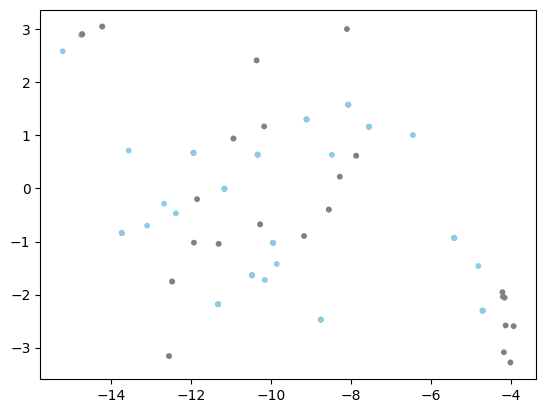

In [21]:
%matplotlib inline

X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label
X_embedded= TSNE(n_components=2, init='random').fit_transform(X_np)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1] , c=labelsNums[:len(X_embedded)], s=10, cmap= cc , alpha=1 )


In [22]:
def clsembed(snippet):
    inputs = tokenizer(snippet, padding='max_length', max_length=218, truncation=True, return_tensors='pt').to(device)
    #tokens = [self.tokenizer.cls_token] + inputs  + [self.tokenizer.sep_token]
    if(len(inputs)<512):
        with torch.no_grad():
            outs = model_codebert(**inputs)
        cls = outs.last_hidden_state[:, 0, :].squeeze().detach()
        return cls
    else:
        print('longtest')
        i = 0
        part_vector =  []
        while ( i < len(inputs)-200) :
            #tokens = [self.tokenizer.cls_token] + inputs[i:i+250] +[self.tokenizer.sep_token]
            #tokens_ids= self.tokenizer.convert_tokens_to_ids(tokens)
            input_seg = [tokenizer.cls_token] + inputs[i:i+250] +[tokenizer.sep_token]
            with torch.no_grad():
                ots = model_codebert(**input_seg)
            cls = ots.last_hidden_state[:, 0, :].squeeze().detach()
            #cls = model_codebert(torch.tensor(inputs)[None,:])[1]
            #vector = cls[0].detach().numpy()
            parts.append(cls)
            i = i+100
        return parts

In [23]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
#labels_all = ['async wait','unordered collections','concurrency','time']
def get_class_rep(post_train_embed, post_train_label):
    # Move each tensor to CPU, convert to numpy, and collect in a list
    #post_train_embed = [x.cpu().numpy() for x in post_train_embed]
    # If you want to combine them into a single array (assuming they have the same shape)
    #post_train_embed = np.concatenate(post_train_embed, axis=0)
    representatives = [None] * 2
    for label in range(2):
        indices = np.where(np.atleast_1d(post_train_label) == label)[0]  # Get the indices as an array
        class_vectors = [post_train_embed[i] for i in indices]  # Access each index individually
        class_vectors = [x.cpu().numpy() for x in class_vectors]
        representatives[label] = np.mean(class_vectors, axis=0)
    return representatives

def calculate_normalized_distance(vec1, vec2):
    # Ensure vec1 and vec2 are numpy arrays
    if not isinstance(vec1, np.ndarray):
        vec1 = vec1.cpu().detach().numpy()
    if not isinstance(vec2, np.ndarray):
        vec2 = vec2.cpu().detach().numpy()
    
    # Normalize each vector to have unit length
    norm_vec1 = vec1 / np.linalg.norm(vec1)
    norm_vec2 = vec2 / np.linalg.norm(vec2)
    
    # Calculate Euclidean (L2) distance between the normalized vectors
    distance = np.linalg.norm(norm_vec1 - norm_vec2)
    
    return distance


In [24]:
int_to_label={
    0: 'notFlaky',
    1: 'Flaky'
    }


def get_closest_cluster(cluster_representatives, projected_vector):
    distances = [calculate_normalized_distance(rep, projected_vector) for rep in cluster_representatives]
    for i in range(len(distances)):
        distances[i] = np.mean(distances[i])
    closest_cluster_idx = np.argmin(distances)
    return int_to_label[closest_cluster_idx]

In [25]:
embed = post_train_embed
labels = post_train_label
def predict(input_vector):
    modified_vector = siamese_network(input_vector)
    representatives = get_class_rep(embed, labels)
    return get_closest_cluster(representatives, modified_vector)
    


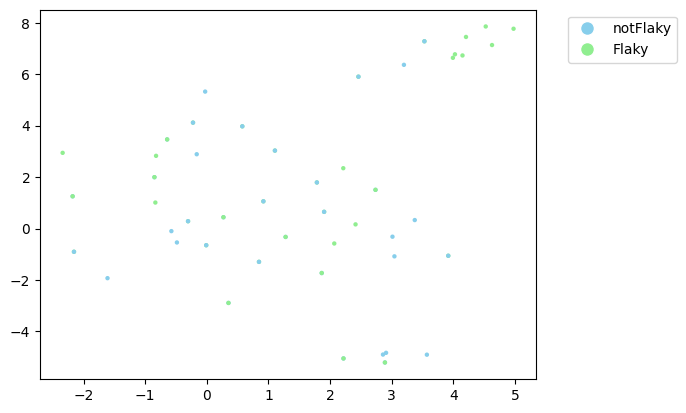

In [26]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed and post_train_label are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
labelsNums = post_train_label

# Define vibrant colors for each category (same as used in the bar plot)
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']

# Ensure labels are within the range of colors [0, 1, 2, 3, 4]
# Filter out invalid labels (-1) and keep only valid labels [0, 1, 2, 3, 4]
valid_indices = [i for i, label in enumerate(labelsNums) if label in [0, 1]]
X_np_filtered = X_np[valid_indices]
labelsNums_filtered = [labelsNums[i] for i in valid_indices]

# Dimensionality reduction with t-SNE
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np_filtered)

# Scatter plot
for i, label in enumerate(labelsNums_filtered):
    plt.scatter(X_embedded[i, 0], X_embedded[i, 1], color=colors[label], s=10, alpha=1, edgecolor='none', marker='o')

# Create legend with category labels
legend_labels = ['notFlaky', 'Flaky']
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors], labels=legend_labels,bbox_to_anchor=(1.05, 1), 
                    loc='upper left')

plt.show()


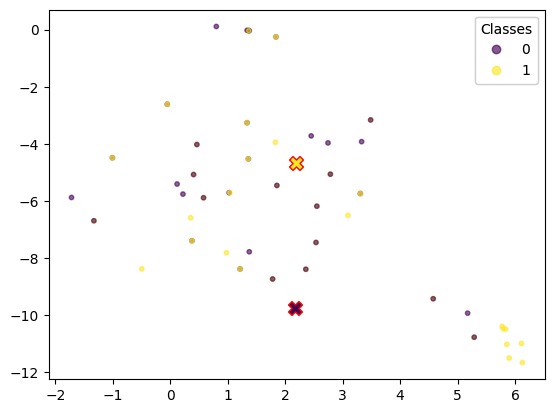

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

# Assuming post_train_embed, post_train_label, and labelsNums are defined
X = torch.stack(post_train_embed).cpu()
X_np = X.numpy()
X_embedded = TSNE(n_components=2, init='random').fit_transform(X_np)

# Plot the data points
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labelsNums[:len(X_embedded)], s=10, cmap='viridis', alpha=0.6)

# Calculate class representatives
representatives = get_class_rep(post_train_embed, post_train_label)  # Make sure this function returns what you expect

# Get unique labels and their colors from the scatter plot
unique_labels = np.unique(labelsNums[:len(X_embedded)])
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# For each class representative, find the closest point and plot it
for i, rep in enumerate(representatives):
    if rep is not None:
        # Find the closest data point in the original space to this representative
        distances = np.linalg.norm(X_np - rep, axis=1)
        closest_point_index = np.argmin(distances)
        # Use the label of the closest data point to get the correct color
        label_of_closest = labelsNums[closest_point_index]
        color = scatter.cmap(scatter.norm(label_of_closest))
        plt.scatter(X_embedded[closest_point_index, 0], X_embedded[closest_point_index, 1], color=color, edgecolors='red', s=100, marker='X')

# You might want to adjust the legend to make sure it correctly represents your data
# plt.legend()
plt.show()


In [28]:
from sklearn.metrics import f1_score
# Create reverse mapping

count = 0

# Assuming val_dataset is iterable and has 'anchor' and 'label' keys
predicted_labels = []
true_labels = []

for item in val_dataset:
    count += 1
    input_vector = item['anchor']  # Your input vector for prediction
    
    # Get predicted cluster/label
    predicted_label_str = predict(input_vector)
    
    # Ensure predicted_label is in the valid range
    if predicted_label_str in label_to_int:
        predicted_label = label_to_int[predicted_label_str]
        predicted_labels.append(predicted_label)
    else:
        print(f"Warning: Encountered unknown predicted label {predicted_label_str}")
        continue

    # True label
    true_label_int = int(item['label'])  # Assuming 'label' contains the true label as integer
    if true_label_int in int_to_label:
        true_labels.append(true_label_int)
    else:
        print(f"Warning: Encountered unknown true label {true_label_int}")
        continue

    print(count, "Predicted:", predicted_label, "True:", true_label_int)

# Filter out any invalid entries where predicted or true labels are missing
valid_indices = [i for i in range(len(true_labels)) if true_labels[i] in int_to_label and predicted_labels[i] in int_to_label]
filtered_true_labels = [true_labels[i] for i in valid_indices]
filtered_predicted_labels = [predicted_labels[i] for i in valid_indices]

print("Loop completed")

# Calculate F1 Score, ignoring unknown labels
f1 = f1_score(filtered_true_labels, filtered_predicted_labels, average='weighted', zero_division=0)  # Adjust 'average' as necessary
print(f"F1 Score: {f1}")


1 Predicted: 0 True: 1
2 Predicted: 0 True: 0
3 Predicted: 0 True: 0
4 Predicted: 0 True: 0
5 Predicted: 1 True: 0
6 Predicted: 0 True: 1
7 Predicted: 0 True: 0
8 Predicted: 0 True: 1
9 Predicted: 0 True: 1
10 Predicted: 0 True: 0
11 Predicted: 0 True: 0
12 Predicted: 0 True: 1
13 Predicted: 0 True: 1
14 Predicted: 0 True: 1
15 Predicted: 0 True: 0
16 Predicted: 0 True: 1
17 Predicted: 0 True: 1
18 Predicted: 0 True: 0
Loop completed
F1 Score: 0.3076923076923077


              precision    recall  f1-score   support

           0       0.47      0.89      0.62         9
           1       0.00      0.00      0.00         9

    accuracy                           0.44        18
   macro avg       0.24      0.44      0.31        18
weighted avg       0.24      0.44      0.31        18


 - Accuracy :  0.44
 - Precision :  0.24
 - Recall :  0.44
 - F1 score :  0.31
 - MCC :  -0.24
 - AUC :  0.44


Performances by categories



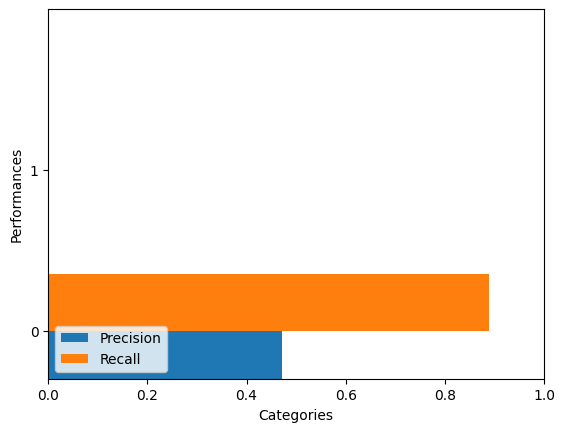



Confusion Matrix 


<AxesSubplot:>

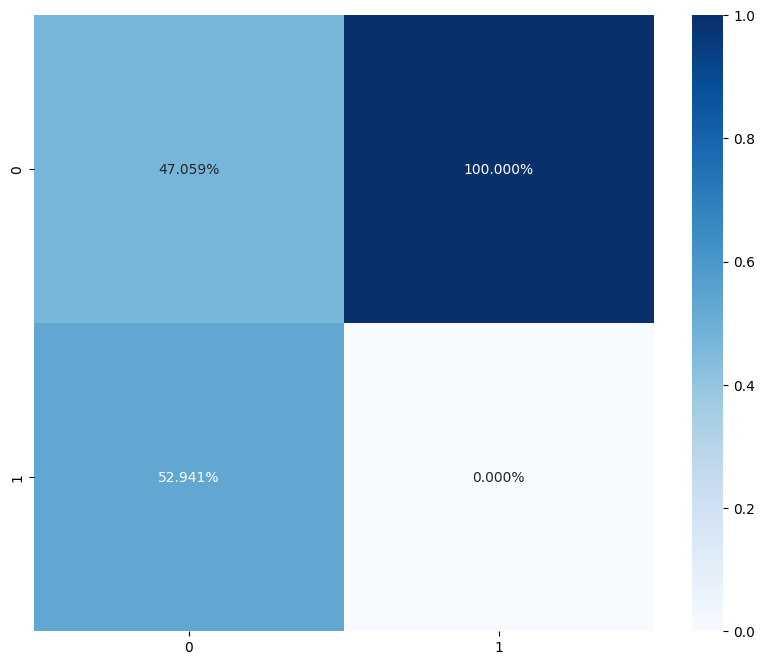

In [29]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

%matplotlib inline
warnings.filterwarnings("ignore")

def multiclass_roc_auc_score(truth, pred, average="weighted"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

# Assuming predicted_labels and true_labels are already defined
predicted = predicted_labels
labels = true_labels

# Filter out 'unknown' labels
valid_indices = [i for i, label in enumerate(labels) if label != 'unknown']
filtered_labels = [labels[i] for i in valid_indices]
filtered_predicted = [predicted[i] for i in valid_indices]

unique_labels = list(set(filtered_labels))
print(classification_report(filtered_labels, filtered_predicted))

print('\n - Accuracy : ', np.round(metrics.accuracy_score(filtered_labels, filtered_predicted), 2))
print(' - Precision : ', np.round(metrics.precision_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - Recall : ', np.round(metrics.recall_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - F1 score : ', np.round(metrics.f1_score(filtered_labels, filtered_predicted, average='weighted'), 2))
print(' - MCC : ', np.round(metrics.matthews_corrcoef(filtered_labels, filtered_predicted), 2))
print(' - AUC : ', np.round(multiclass_roc_auc_score(filtered_labels, filtered_predicted), 2))

print("\n\nPerformances by categories\n")

ind = np.arange(len(unique_labels)) 
width = 0.35
fig, ax = plt.subplots()
precision = metrics.precision_recall_fscore_support(filtered_labels, filtered_predicted, labels=unique_labels)[0]
recall = metrics.precision_recall_fscore_support(filtered_labels, filtered_predicted, labels=unique_labels)[1]
ax.barh(ind - width/2, precision, width, label='Precision')
ax.barh(ind + width/2, recall, width, label='Recall')
ax.set(yticks=ind, yticklabels=np.array(unique_labels), ylim=[2*width - 1, len(ind)])
plt.xlim(0, 1)
ax.legend(loc='lower left')
ax.set_ylabel("Performances")
ax.set_xlabel("Categories")
plt.show()

print("\n\nConfusion Matrix ")

mat = confusion_matrix(filtered_labels, filtered_predicted, labels=unique_labels)
df_cm = pd.DataFrame(mat, index=[i for i in unique_labels], columns=[i for i in unique_labels])
plt.figure(figsize=(10, 8))
sn.heatmap(df_cm / np.sum(df_cm), annot=True, fmt='.3%', cmap='Blues')


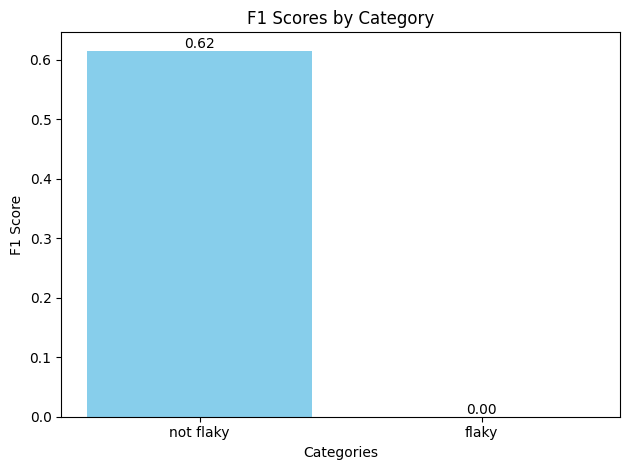

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
shortened_labels = {
    'notFlaky':'not flaky',
    'Flaky': 'flaky'
}
# Assuming you have the predicted and true labels as per your previous code
# predicted_labels and true_labels should be lists of labels
# Filter out invalid labels from both true and predicted labels
valid_indices = [i for i in range(len(true_labels)) if true_labels[i] in int_to_label.keys() and predicted_labels[i] in int_to_label.keys()]
filtered_true_labels = [true_labels[i] for i in valid_indices]
filtered_predicted_labels = [predicted_labels[i] for i in valid_indices]

# Calculate F1 scores for each category
f1_scores = []
categories = list(int_to_label.keys())
for category in categories:
    true_bin = [1 if label == category else 0 for label in filtered_true_labels]
    pred_bin = [1 if label == category else 0 for label in filtered_predicted_labels]
    f1 = f1_score(true_bin, pred_bin, zero_division=0)
    f1_scores.append(f1)

# Define vibrant colors for each category
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'grey']

# Create bar plot with shortened category names and vibrant colors
shortened_categories = [shortened_labels[int_to_label[category]] for category in categories]
fig, ax = plt.subplots()
bars = ax.bar(shortened_categories, f1_scores, color=colors)

# Add F1 scores on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 0),  
                textcoords="offset points", ha='center', va='bottom')

# Customize the plot
ax.set_xlabel('Categories')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Category')

# Display the plot
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
